In [ ]:
import pandas as pd
import numpy as np

n = ['id', 'date', 'name', 'text', 'typr', 'rep', 'rtw', 'faw', 'stcount', 'foll', 'frien', 'listcount']
data_positive = pd.read_csv('/content/drive/MyDrive/data/positive.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])
data_negative = pd.read_csv('/content/drive/MyDrive/data/negative.csv', sep=';', error_bad_lines=False, names=n, usecols=['text'])

sample_size = min(data_positive.shape[0], data_negative.shape[0])
raw_data = np.concatenate((data_positive['text'].values[:sample_size],
                           data_negative['text'].values[:sample_size]), axis=0)
labels = [1] * sample_size + [0] * sample_size

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re

def preprocess_text(text):
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip()


data = [preprocess_text(t) for t in raw_data]

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=2)

In [ ]:
from keras import backend as K


def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

SENTENCE_LENGTH = 26
NUM = 100000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=SENTENCE_LENGTH)

tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(x_train)

x_train_seq = get_sequences(tokenizer, x_train)
x_test_seq = get_sequences(tokenizer, x_test)

In [ ]:
from gensim.models import Word2Vec
# Загружаем обученную модель
w2v_model = Word2Vec.load('/content/drive/MyDrive/models/w2v/tweets_model.w2v')
DIM = w2v_model.vector_size 
# Инициализируем матрицу embedding слоя нулями
embedding_matrix = np.zeros((NUM, DIM))
# Добавляем NUM=100000 наиболее часто встречающихся слов из обучающей выборки в embedding слой
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in w2v_model.wv.vocab.keys():
        embedding_matrix[i] = w2v_model.wv[word]

In [ ]:
from keras.layers import Input
from keras.layers.embeddings import Embedding

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[embedding_matrix], trainable=False)(tweet_input)

In [ ]:
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

branches = []
x = Dropout(0.2)(tweet_encoder)

for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)

x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 200)      20000000    input_4[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 26, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_80 (Conv1D)              (None, 25, 1)        401         dropout_4[0][0]                  
____________________________________________________________________________________________

## 5. Training and evaluating the CNN

The dataset was divided into three parts: train dataset (60% of the entire dataset), validation dataset (20% of the entire dataset), and test dataset (20% of the entire dataset). The loss function was minimized using the Adam optimizer with a learning rate of 0.001. The embedding layer, which was initialized with Word2Vec word embeddings, was frozen for the first 10 epochs. Then we train model from the previous step with best validation scores for additional 5 epochs with unfrozen embeddings and a learning rate of 0.0001. The best results in terms of F-measure was 77.67%. 

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


In [ ]:
try:
  import tensorflow.compat.v2 as tf
except Exception:
  pass

tf.enable_v2_behavior()

print(tf.__version__)

2.6.0


In [ ]:
!tf_upgrade_v2 -h


usage: tf_upgrade_v2 [-h] [--infile INPUT_FILE] [--outfile OUTPUT_FILE]
                     [--intree INPUT_TREE] [--outtree OUTPUT_TREE]
                     [--copyotherfiles COPY_OTHER_FILES] [--inplace]
                     [--import_rename] [--reportfile REPORT_FILENAME]
                     [--mode {DEFAULT,SAFETY}] [--print_all]

Convert a TensorFlow Python file from 1.x to 2.0

Simple usage:
  tf_upgrade_v2.py --infile foo.py --outfile bar.py
  tf_upgrade_v2.py --infile foo.ipynb --outfile bar.ipynb
  tf_upgrade_v2.py --intree ~/code/old --outtree ~/code/new

optional arguments:
  -h, --help            show this help message and exit
  --infile INPUT_FILE   If converting a single file, the name of the file to
                        convert
  --outfile OUTPUT_FILE
                        If converting a single file, the output filename.
  --intree INPUT_TREE   If converting a whole tree of files, the directory to
                        read from (relative or absolute).
  --ou

In [ ]:
from keras.callbacks import ModelCheckpoint


checkpoint = ModelCheckpoint("/content/drive/MyDrive/models/cnn/cnn-frozen-embeddings-09-0.77.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', save_freq = 10)


x_train_seq = np.asarray(x_train_seq)
y_train = np.asarray(y_train)


history = model.fit(x=x_train_seq, y=y_train, batch_size=32, validation_split=0.25, callbacks = [checkpoint])

4198/4198 [==============================] - 454s 107ms/step - loss: 0.5691 - precision: 0.6976 - recall: 0.6947 - f1: 0.6875 - val_loss: 0.4981 - val_precision: 0.7705 - val_recall: 0.7175 - val_f1: 0.7363


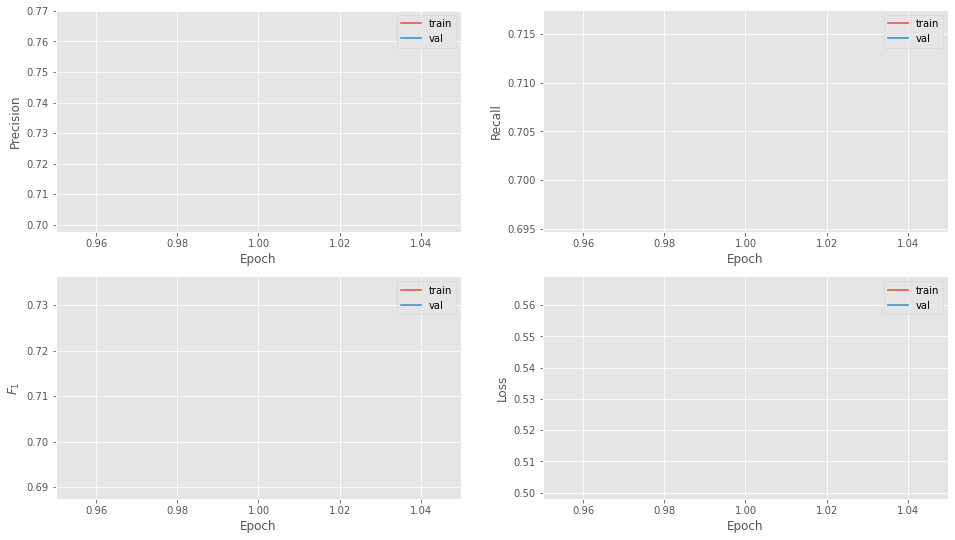

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')

    plt.show()


plot_history(history)

In [ ]:
model.load_weights('/content/drive/MyDrive/models/cnn/cnn-frozen-embeddings-09-0.77.hdf5')

In [ ]:
from sklearn.metrics import classification_report

predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.77503   0.77272   0.77388     22457
           1    0.77194   0.77426   0.77310     22313

    accuracy                        0.77349     44770
   macro avg    0.77349   0.77349   0.77349     44770
weighted avg    0.77349   0.77349   0.77349     44770



In [ ]:
from keras import optimizers

model.layers[1].trainable = True

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[precision, recall, f1])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 26, 200)      20000000    input_4[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 26, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_80 (Conv1D)              (None, 25, 1)        401         dropout_4[0][0]                  
____________________________________________________________________________________________

In [ ]:
checkpoint = ModelCheckpoint("models/cnn/cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(x_train_seq, y_train, batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

Epoch 1/5
4198/4198 [==============================] - 1487s 353ms/step - loss: 0.4642 - precision: 0.7734 - recall: 0.7712 - f1: 0.7660 - val_loss: 0.4499 - val_precision: 0.7975 - val_recall: 0.7614 - val_f1: 0.7730
Epoch 2/5
4198/4198 [==============================] - 1331s 317ms/step - loss: 0.4224 - precision: 0.8013 - recall: 0.7981 - f1: 0.7942 - val_loss: 0.4434 - val_precision: 0.7967 - val_recall: 0.7732 - val_f1: 0.7791
Epoch 3/5
4198/4198 [==============================] - 1321s 315ms/step - loss: 0.3809 - precision: 0.8309 - recall: 0.8207 - f1: 0.8207 - val_loss: 0.4455 - val_precision: 0.8036 - val_recall: 0.7690 - val_f1: 0.7801
Epoch 4/5
4198/4198 [==============================] - 1308s 312ms/step - loss: 0.3433 - precision: 0.8548 - recall: 0.8394 - f1: 0.8424 - val_loss: 0.4536 - val_precision: 0.8191 - val_recall: 0.7315 - val_f1: 0.7663
Epoch 5/5
4198/4198 [==============================] - 1320s 314ms/step - loss: 0.3063 - precision: 0.8769 - recall: 0.8586 - f1

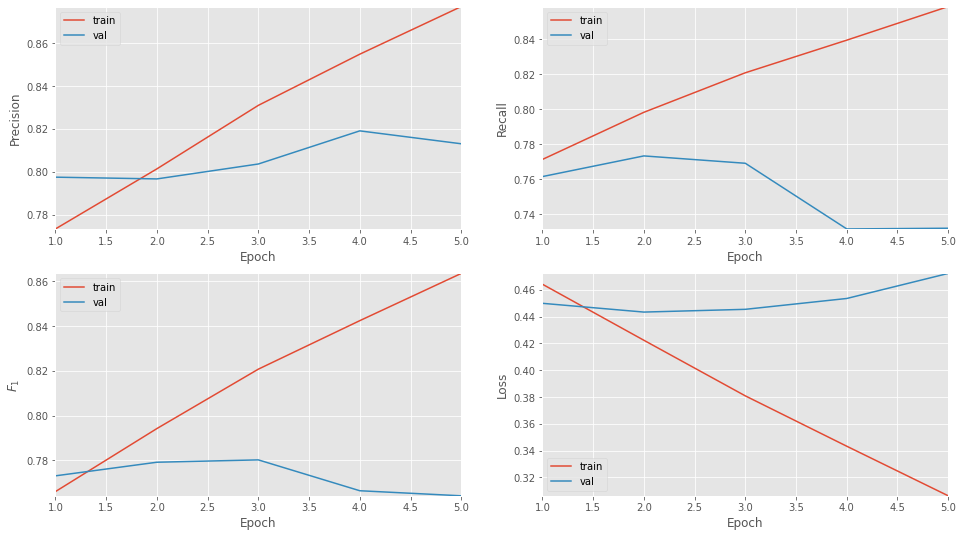

In [ ]:
plot_history(history_trainable)

In [ ]:
model.load_weights('models/cnn/cnn-trainable-03-0.78.hdf5')

In [ ]:
predicted = np.round(model.predict(x_test_seq))
print(classification_report(y_test, predicted, digits=5))

              precision    recall  f1-score   support

           0    0.77653   0.81422   0.79493     22457
           1    0.80342   0.76417   0.78331     22313

    accuracy                        0.78928     44770
   macro avg    0.78998   0.78920   0.78912     44770
weighted avg    0.78993   0.78928   0.78914     44770



In [ ]:
data1 = ["алексей ну ты алексей здраствуйте", "алексей ну ты алексей здраствуйте", "алексей ну ты алексей здраствуйте"]
x_train, x_test, y_train, y_test = train_test_split(data1)
print(data[64457])

ValueError: ignored

## Conclusion
This model was evaluated on the test dataset and demonstrated F-measure score up to 78.14%.

## References

1. Y. Rubtsova, "Constructing a Corpus for Sentiment Classification Training", Software & Systems, vol. 109, no. 1, pp. 72-78, 2015.
2. T. Mikolov, I. Sutskeve, K. Chen, G. Corrado and J. Dean, "Distributed Representations of Words and Phrases and their Compositionality", <i>Advances in Neural Information Processing Systems</i>, vol. 26, pp. 3111-3119, 2013.
3. Y. Zhang and B. Wallace, "A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification", <i>arXiv preprint arXiv:1510.03820</i>, 2015.
4. M. Cliche, "BB_twtr at SemEval-2017 Task 4: Twitter Sentiment Analysis with CNNs and LSTMs", <i>Proceedings of the 11th International Workshop on Semantic Evaluation (SemEval-2017)</i>, pp. 573-580, 2017.